# Inverse Compton Scattering

In this notebook, we demonstrate the full inverse Compton scattering code, which converts an initial primary electron input to a final, fully resolved secondary photon spectrum. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
import darkhistory.history.tla as tla

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_spectrum import nonrel_spec
from darkhistory.electrons.ics.ics_spectrum import rel_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

np.set_printoptions(threshold=np.nan)

## Computing the ICS Spectra

### Scattered Photon Spectrum in the Thomson Regime

In [3]:
nEe = 500
nEp = 500

Emax = 1.1e10
Emin = 0.9e-8

dlnEp = np.log(Emax/Emin)/nEp
lowengEp = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
lowengEe = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_thomson_tf = nonrel_spec(lowengEe, lowengEp, 0.25)

Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


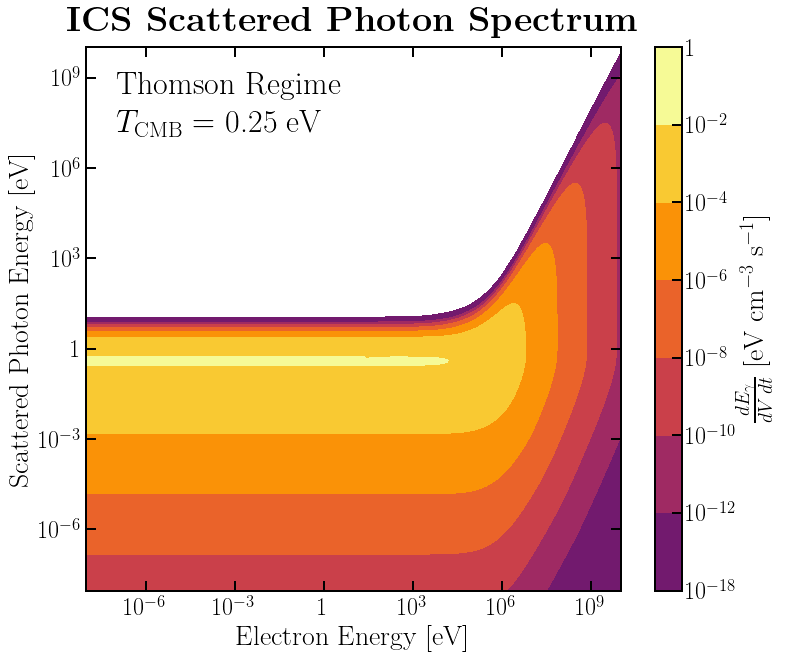

In [4]:
plt.figure(figsize=[12,10])

plt.contourf(
    lowengEe, lowengEp, np.transpose(ics_thomson_tf.grid_vals), 
    levels=10.**np.array([-18, -12, -10, -8, -6, -4, -2, 0]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.colorbar(label=r'$\frac{dE_\gamma}{dV \, dt}$ [eV cm$^{-3}$ s$^{-1}$]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Scattered Photon Spectrum}')
plt.xlabel('Electron Energy [eV]')
plt.ylabel('Scattered Photon Energy [eV]')

plt.text(1e-7, 3e8, 'Thomson Regime', fontsize=32)
plt.text(1e-7, 1e7, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=32)

plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_thomson_scattered_phot_spec.pdf')

### Scattered Photon Spectrum in the Relativistic Regime

In [5]:
Emax_rel = 1e20
Emin_rel = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax_rel/Emin_rel)/nEp
lowengEp_rel = Emin_rel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_rel/Emin_rel)/nEe
lowengEe_rel = Emin_rel*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_rel_tf = rel_spec(phys.me+lowengEe_rel, lowengEp_rel, 0.25, inf_upp_bound=True)

Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


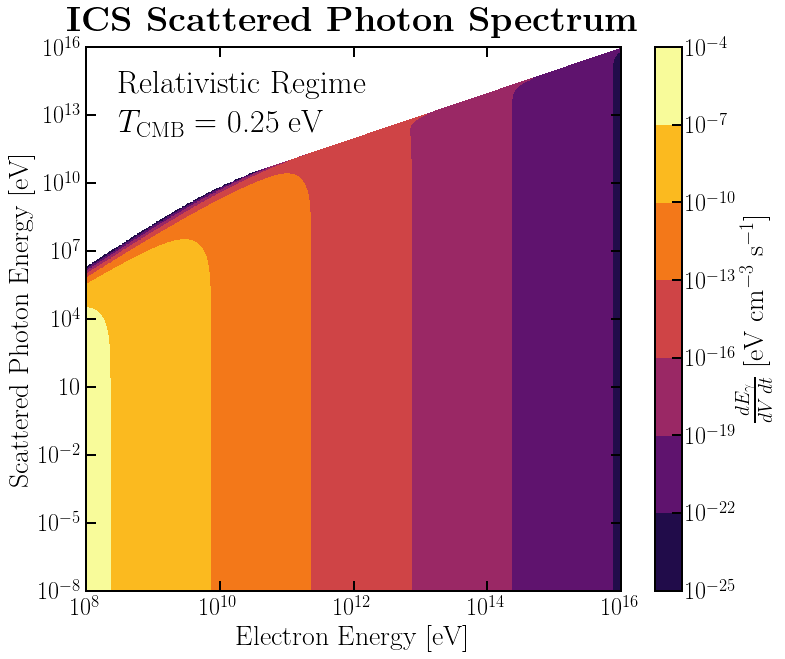

In [6]:
plt.figure(figsize=[12,10])

plt.contourf(
    phys.me+lowengEe_rel, lowengEp_rel, np.transpose(ics_rel_tf.grid_vals), 
    levels=10.**np.array([-25, -22, -19, -16, -13, -10, -7, -4]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.colorbar(label=r'$\frac{dE_\gamma}{dV \, dt}$ [eV cm$^{-3}$ s$^{-1}$]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Scattered Photon Spectrum}')
plt.xlabel('Electron Energy [eV]')
plt.ylabel('Scattered Photon Energy [eV]')

plt.text(3e8, 1e14, 'Relativistic Regime', fontsize=32)
plt.text(3e8, 1e12, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=32)

plt.axis([1e8, 1e16, 1e-8, 1e16])

plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_rel_scattered_phot_spec.pdf')

### Mean Electron Energy Loss Spectrum

In [30]:
Emax_rel = 1e10
Emin_rel = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax_rel/Emin_rel)/nEp
lowengEp_rel = Emin_rel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_rel/Emin_rel)/nEe
lowengEe_rel = Emin_rel*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_engloss_tf = engloss_spec(lowengEe_rel, lowengEp_rel, 0.25, nonrel=True)

Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
Computing integrals 1/6...
Computing integrals 2/6...
Computing integrals 3/6...
Computing integrals 4/6...
Computing integrals 5/6...
Computing integrals 6/6...
Integrals computed!
Computation by expansion in beta complete!
Computing energy loss spectrum by analytic series...
Computing upscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...
Computing series 6/7...
Computing series 7/7...
Computing downscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...
Computing series 6/7...
Computing series 7/7...
Computing additional spectra for new spec_type...
Computing series 1/2...
Computing series 2/2...
Nonrelativistic energy loss spectrum computed!


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


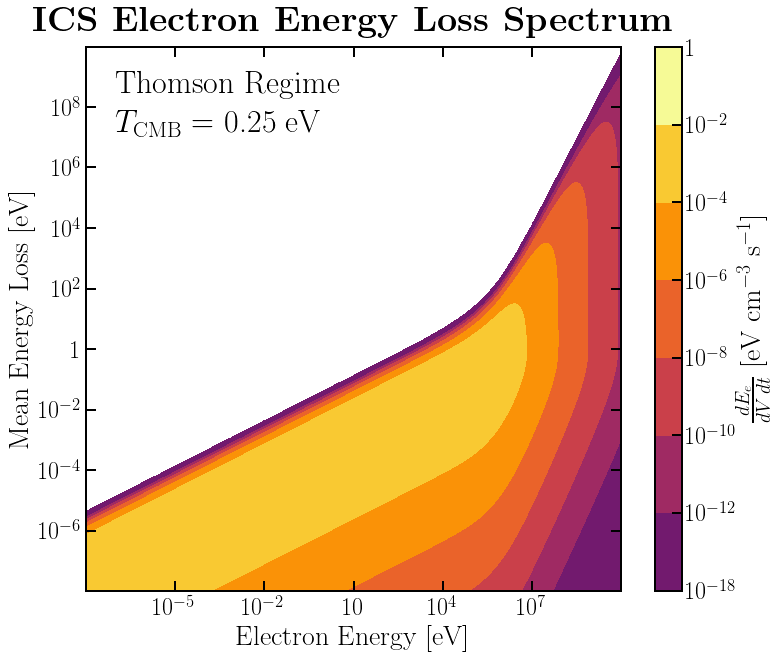

In [31]:
plt.figure(figsize=[12,10])

plt.contourf(
    lowengEe_rel, lowengEp_rel, np.transpose(ics_engloss_tf.grid_vals), 
    levels=10.**np.array([-18, -12, -10, -8, -6, -4, -2, 0]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.colorbar(label=r'$\frac{dE_e}{dV \, dt}$ [eV cm$^{-3}$ s$^{-1}$]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Electron Energy Loss Spectrum}')
plt.xlabel('Electron Energy [eV]')
plt.ylabel('Mean Energy Loss [eV]')

plt.text(1e-7, 3e8, 'Thomson Regime', fontsize=32)
plt.text(1e-7, 1e7, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=32)

# plt.axis([1e-8, 1e16, 1e-8, 1e16])

plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_thomson_engloss_spec.pdf')

## Secondary Photon Spectrum

With these single-scattering transfer functions, we can now compute the secondary photon spectrum transfer function, which takes injected electrons through its complete cooling process, and produces a final secondary photon spectrum and low energy (sub 3 keV) electron spectrum. This is computed through the function `electrons.ics.ics_cooling.get_ics_cooling_tf()`. 

We will perform this computation by interpolation of a reference transfer function, evaluated at a temperature of $1000 T_{\mathrm{CMB},0}$. This is done in `DarkHistory` for speed. First, we define the abscissa (this is sufficient for redshifts from $1+z = 3000$ down to $1 + z = 4$):

In [10]:
Emax = 1e20
Emin = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax/Emin)/nEp
lowengEp_rel = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_rel = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

Emax = 1e10
Emin = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax/Emin)/nEp
lowengEp_nonrel = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)  

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_nonrel = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)


Next, we compute all of the reference scattered photon spectra (Thomson and relativistic) and the energy loss spectrum:

In [11]:
print('********* Thomson regime scattered photon spectrum *********')
ics_thomson_ref_tf = nonrel_spec(lowengEe_nonrel, lowengEp_nonrel, phys.TCMB(1000))
print('********* Relativistic regime scattered photon spectrum *********')
ics_rel_ref_tf = rel_spec(lowengEe_rel, lowengEp_rel, phys.TCMB(1000), inf_upp_bound=True)
print('********* Thomson regime energy loss spectrum *********')
engloss_ref_tf = engloss_spec(lowengEe_nonrel, lowengEp_nonrel, phys.TCMB(1000), nonrel=True)

********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

Now we compute the full ICS secondary photon spectrum, as well as the low energy secondary electron spectrum that are produced after the electrons cool completely. 

In [22]:
eleceng = 10**np.arange(2, 12, 0.025)
photeng = 10**np.arange(-4, 12, 0.025)

(ics_sec_phot_tf, ics_sec_elec_tf) = get_ics_cooling_tf(ics_thomson_ref_tf,
                                                     ics_rel_ref_tf,
                                                     engloss_ref_tf,
                                                     eleceng, photeng, 0.25/phys.TCMB(1))


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


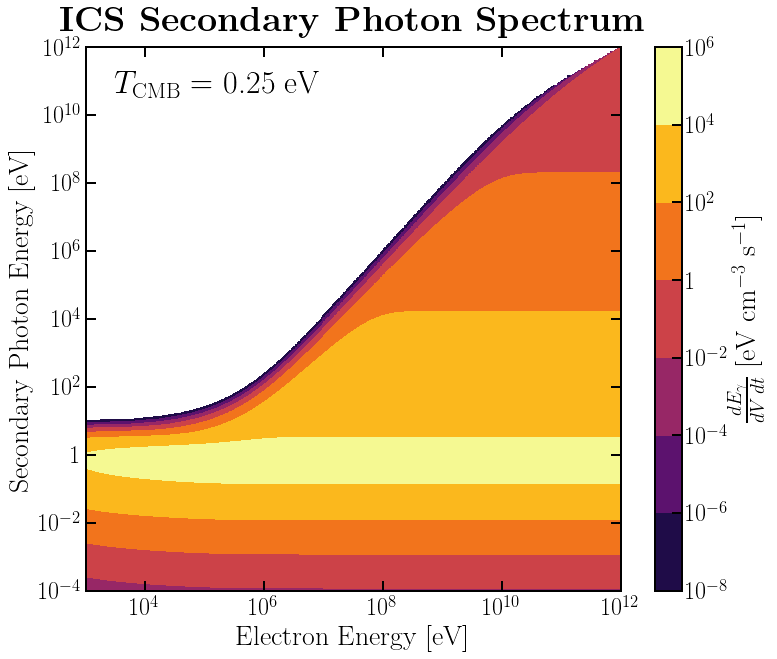

In [28]:
plt.figure(figsize=[12,10])

ax = plt.gca()

plt.contourf(
    eleceng, photeng, np.transpose(ics_sec_phot_tf.grid_vals), 
    levels=10.**np.array([ -8, -6, -4, -2, 0, 2, 4, 6]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.text(3e3, 3e10, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=32)

plt.colorbar(label=r'$\frac{dE_\gamma}{dV \, dt}$ [eV cm$^{-3}$ s$^{-1}$]')

plt.title(r'\textbf{ICS Secondary Photon Spectrum}')
plt.xlabel('Electron Energy [eV]')
plt.ylabel('Secondary Photon Energy [eV]')

ax.set_xscale('log')
ax.set_yscale('log')

plt.axis([1e3, 1e12, 1e-4, 1e12])

plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_sec_phot_spec.pdf')

## Plot for Thesis Presentation (REMOVE!)

In [ ]:
plt.figure()

ax = plt.gca()
comp_elec_kineng = np.array([5e3, 5e5, 5e7, 5e9])
if ics_phot_tf.spec_type != 'dNdE':
    ics_phot_tf.switch_spec_type()
# ics_phot_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng')
if raw_nonrel_ICS_tf.spec_type != 'dNdE':
    raw_nonrel_ICS_tf.switch_spec_type()
if raw_rel_ICS_tf.spec_type != 'dNdE':
    raw_rel_ICS_tf.switch_spec_type()
raw_nonrel_ICS_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng')
raw_rel_ICS_tf.plot(ax, ind=np.array([5e10, 5e11, 5e12]), indtype='in_eng')
# ICS_test_tf.plot(
#     ax, ind=comp_elec_kineng, indtype='in_eng', 
#     linewidth=0, marker='o', markersize='10', 
#     markerfacecolor='w', markevery=15,
# )

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel(r'$dN/dE$ [eV$^{-1}$]')
plt.title('Secondary Photon Spectrum')
leg = ax.legend(['5 keV', '500 keV', '50 MeV', '5 GeV', '50 GeV', '500 GeV', '5 TeV'], title='Primary Electron Energy', ncol=2)
plt.setp(leg.get_title(),fontsize=28)

plt.axis([1e-4, 1e14, 1e-20, 1000])

plt.show()



Now, scatter the initial photons through the full ICS transfer function. This is easily accomplished using the function `spec.spectools.scatter()`. This function takes in a transfer function, and applies it to an initial spectrum, producing the final spectrum after the scattering. The transfer function `spec_type` determines whether the transfer function acts as a map of number of particles to number of particles in each bin, or $dN/dE$ to $dN/dE$ in each bin. The `spec_type` of the input spectrum will be switched automatically based on this within the function, and the output has the same `spec_type` as the input. 

In [ ]:
phot_spec_init = spectools.scatter(ics_phot_tf, elec_spec_init, new_eng=photeng)